<a href="https://colab.research.google.com/github/lorenzofamiglini/Deep-Learning/blob/master/Transfer_Learning_ML_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import seaborn as sns
import keras
from keras.models import Model
from keras.layers import Dense
import keras
from keras.preprocessing import image as kimage
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import resnet_v2
import tensorflow as tf
import skimage
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = []
test = []
train_labels = []
test_labels = []
lista = ["scissors", "scorpion","sea_horse","snoopy","soccer_ball","stapler",
         "starfish", "stegosaurus","stop_sign","strawberry"]
fold = ["train_copy/", "test_copy/"]
for j in fold:
    for i in range(len(lista)):
        path = "/content/drive/My Drive/Dataset/"+j+lista[i]+"/"
        Class=os.listdir(path)
        for a in Class:
          image = Image.open(path+a)
          imResize = image.resize((224,224), Image.ANTIALIAS)
          #image_from_array = Image.fromarray(image, 'RGB')
          if (j == "train_copy/"):
          #size_image = image_from_array.resize((height, width))
              train.append(np.asarray(imResize))
              train_labels.append(str(lista[i]))
          else:
              test.append(np.asarray(imResize))
              test_labels.append(str(lista[i]))

In [0]:
X_train = train
y_train = train_labels
X_test = test
y_test = test_labels

In [0]:
X_train[0].shape

(224, 224)

In [0]:
import pdb

In [0]:
def add_3d(x):
  l = []
  for i in x:
    #pdb.set_trace()
    if i.shape == (224,224):
      img2 = np.stack((i,i,i), axis = -1)
      l.append(img2)
    else:
      l.append(i)
  return np.asarray(l)

In [0]:
X_train = add_3d(X_train)
X_test = add_3d(X_test)

scissors


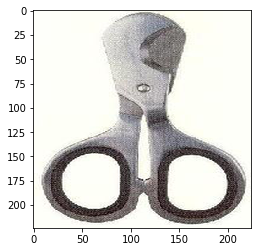

In [0]:
print(str(y_test[0]))
plt.imshow(X_test[0])

In [0]:
X_train[0].shape

(224, 224, 3)

In [0]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train,y_train, random_state=1)
X_test, y_test = shuffle(X_test,y_test, random_state=1)

In [0]:
train_img_pro = kimage.ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input)
test_img_pro = kimage.ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input)

In [0]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
dummy_y = keras.utils.np_utils.to_categorical(y_train)
y_test = encoder.transform(y_test)
dummy_val = keras.utils.np_utils.to_categorical(y_test)

In [0]:
dummy_y.shape

(287, 10)

In [0]:
"""
train_generator = train_img_pro.flow_from_directory(directory = "/content/drive/My Drive/Dataset/train_copy",
                    target_size=(224, 224),
                    color_mode = "rgb",
                    batch_size = 28,  
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 1)
test_genrator = test_img_pro.flow_from_directory(directory = "/content/drive/My Drive/Dataset/test_copy",
                    target_size=(224, 224),
                    color_mode = "rgb",
                    batch_size = 28,  
                    class_mode = 'categorical',
                    shuffle = True,
                    seed = 1)
"""

'\ntrain_generator = train_img_pro.flow_from_directory(directory = "/content/drive/My Drive/Dataset/train_copy",\n                    target_size=(224, 224),\n                    color_mode = "rgb",\n                    batch_size = 28,  \n                    class_mode = \'categorical\',\n                    shuffle = True,\n                    seed = 1)\ntest_genrator = test_img_pro.flow_from_directory(directory = "/content/drive/My Drive/Dataset/test_copy",\n                    target_size=(224, 224),\n                    color_mode = "rgb",\n                    batch_size = 28,  \n                    class_mode = \'categorical\',\n                    shuffle = True,\n                    seed = 1)\n'

In [0]:
base_net = resnet_v2.ResNet50V2(input_shape=(224,224,3),
                         include_top=False, #ignorare l'ultimo fully connected
                         weights='imagenet', #pesi ottimizzati su imagenet
                         pooling='avg')

94674944/94668760 [==============================] - 4s 0us/step


In [0]:
generator_train = train_img_pro.flow(X_train, dummy_y)
generator_test = test_img_pro.flow(X_test, dummy_val, shuffle = False)

In [0]:
for layer in base_net.layers:
  layer.trainable = False #Blocchiamo tutti i livelli della rete e non alleniamoli

x = base_net.output
x = Dense(1024, activation = "relu")(x)
x = Dense(128, activation = "relu")(x)
pred = Dense(10, activation = "softmax")(x)
net = Model(inputs=base_net.input, outputs = pred)
net.compile(loss = keras.losses.categorical_crossentropy, optimizer = "adam", metrics = ['accuracy'])
net.fit_generator(generator_train,validation_data = generator_test,
                  epochs=5)

Epoch 1/5
9/9 [==============================] - 13s 1s/step - loss: 1.0014 - acc: 0.6941 - val_loss: 0.1158 - val_acc: 0.9680
Epoch 2/5
9/9 [==============================] - 4s 433ms/step - loss: 0.1694 - acc: 0.9336 - val_loss: 0.2921 - val_acc: 0.9110
Epoch 3/5
9/9 [==============================] - 4s 429ms/step - loss: 0.0547 - acc: 0.9755 - val_loss: 0.1454 - val_acc: 0.9680
Epoch 4/5
9/9 [==============================] - 4s 432ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.3415 - val_acc: 0.9502
Epoch 5/5
9/9 [==============================] - 4s 434ms/step - loss: 0.0162 - acc: 0.9965 - val_loss: 0.2554 - val_acc: 0.9609


In [0]:
#net.evaluate_generator(generator_test)
net.evaluate_generator(generator_train)

[0.12033254909734745, 0.9686411149825784]

In [0]:
generator_test.reset()
classes = generator_test.y[generator_test.index_array].argmax(axis = -1)
y_pred = net.predict_generator(generator_test).argmax(axis = -1)

In [0]:
generator_test.x[generator_test.index_array][0].shape

(224, 224, 3)

In [0]:
w = pd.DataFrame(y_pred, columns = ["pred"])
w['pred'] = w['pred'].map({0: 'scissors', 1: 'scorpion',2 : 'sea_horse',3:'snoopy',
                           4 : 'soccer_ball', 5 : 'stapler', 6:'starfish', 7 : 'stegosaurus',
                           8 : 'stop_sign', 9:'strawberry'})

In [0]:
classes

array([3, 8, 2, 3, 8, 7, 3, 4, 0, 6, 4, 5, 3, 3, 5, 4, 8, 0, 0, 9, 4, 1,
       6, 6, 5, 7, 6, 5, 9, 9, 2, 6, 6, 9, 7, 0, 0, 6, 1, 7, 8, 7, 1, 9,
       6, 2, 0, 1, 5, 1, 4, 9, 2, 2, 6, 7, 2, 1, 6, 1, 1, 5, 4, 5, 3, 6,
       7, 1, 0, 6, 9, 1, 5, 6, 7, 8, 9, 4, 9, 4, 0, 8, 8, 1, 5, 1, 4, 7,
       5, 1, 7, 4, 6, 1, 3, 4, 1, 6, 2, 1, 0, 7, 4, 7, 2, 9, 1, 0, 6, 6,
       2, 9, 4, 1, 6, 8, 3, 6, 1, 1, 3, 8, 2, 1, 5, 2, 7, 4, 8, 9, 4, 6,
       6, 1, 2, 6, 6, 2, 7, 4, 7, 4, 6, 9, 7, 1, 8, 7, 6, 6, 3, 6, 4, 3,
       8, 2, 7, 1, 3, 5, 7, 5, 5, 8, 7, 2, 4, 7, 7, 0, 3, 7, 1, 6, 3, 1,
       8, 1, 8, 6, 2, 6, 8, 8, 8, 0, 8, 0, 4, 8, 2, 4, 2, 6, 5, 6, 1, 6,
       2, 3, 6, 7, 2, 5, 8, 0, 6, 1, 4, 6, 2, 8, 6, 5, 3, 4, 1, 4, 6, 0,
       8, 3, 5, 9, 4, 9, 4, 1, 8, 2, 0, 7, 1, 9, 4, 2, 1, 1, 2, 1, 1, 6,
       0, 1, 1, 5, 6, 4, 9, 1, 6, 4, 8, 6, 4, 8, 7, 7, 0, 1, 0, 5, 2, 8,
       7, 2, 1, 5, 8, 8, 6, 8, 2, 4, 5, 4, 7, 8, 2, 8, 1])

In [0]:
y_test

array([3, 8, 2, 3, 8, 7, 3, 4, 0, 6, 4, 5, 3, 3, 5, 4, 8, 0, 0, 9, 4, 1,
       6, 6, 5, 7, 6, 5, 9, 9, 2, 6, 6, 9, 7, 0, 0, 6, 1, 7, 8, 7, 1, 9,
       6, 2, 0, 1, 5, 1, 4, 9, 2, 2, 6, 7, 2, 1, 6, 1, 1, 5, 4, 5, 3, 6,
       7, 1, 0, 6, 9, 1, 5, 6, 7, 8, 9, 4, 9, 4, 0, 8, 8, 1, 5, 1, 4, 7,
       5, 1, 7, 4, 6, 1, 3, 4, 1, 6, 2, 1, 0, 7, 4, 7, 2, 9, 1, 0, 6, 6,
       2, 9, 4, 1, 6, 8, 3, 6, 1, 1, 3, 8, 2, 1, 5, 2, 7, 4, 8, 9, 4, 6,
       6, 1, 2, 6, 6, 2, 7, 4, 7, 4, 6, 9, 7, 1, 8, 7, 6, 6, 3, 6, 4, 3,
       8, 2, 7, 1, 3, 5, 7, 5, 5, 8, 7, 2, 4, 7, 7, 0, 3, 7, 1, 6, 3, 1,
       8, 1, 8, 6, 2, 6, 8, 8, 8, 0, 8, 0, 4, 8, 2, 4, 2, 6, 5, 6, 1, 6,
       2, 3, 6, 7, 2, 5, 8, 0, 6, 1, 4, 6, 2, 8, 6, 5, 3, 4, 1, 4, 6, 0,
       8, 3, 5, 9, 4, 9, 4, 1, 8, 2, 0, 7, 1, 9, 4, 2, 1, 1, 2, 1, 1, 6,
       0, 1, 1, 5, 6, 4, 9, 1, 6, 4, 8, 6, 4, 8, 7, 7, 0, 1, 0, 5, 2, 8,
       7, 2, 1, 5, 8, 8, 6, 8, 2, 4, 5, 4, 7, 8, 2, 8, 1])

In [0]:
from sklearn.metrics import classification_report
print(classification_report(classes,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      1.00      0.97        42
           2       1.00      0.68      0.81        28
           3       0.94      0.94      0.94        17
           4       1.00      1.00      1.00        32
           5       1.00      0.95      0.98        22
           6       0.98      1.00      0.99        43
           7       0.85      1.00      0.92        29
           8       1.00      1.00      1.00        32
           9       0.94      1.00      0.97        17

    accuracy                           0.96       281
   macro avg       0.96      0.96      0.96       281
weighted avg       0.96      0.96      0.96       281



In [0]:
generator_test.x[1].shape

(224, 224, 3)

In [0]:
classes[:5]

array([3, 8, 2, 3, 8])

In [0]:
y_test[0]

3

Predicted image: snoopy


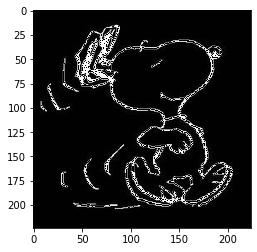

Predicted image: stop_sign


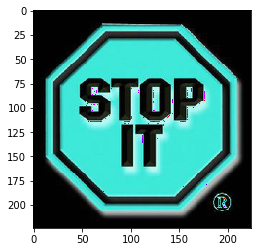

Predicted image: starfish


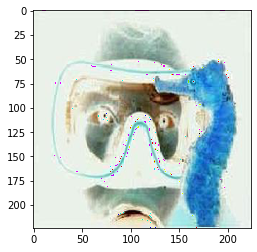

Predicted image: snoopy


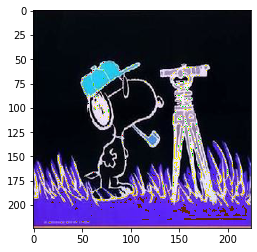

Predicted image: stop_sign


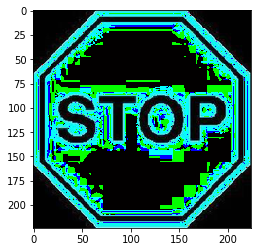

In [0]:
for i in range(0,5):
  print("Predicted image: " + w.pred[i])
  plt.imshow((generator_test.x[generator_test.index_array][i]*255).astype(np.uint8))
  plt.show()

In [0]:
generator_train = train_img_pro.flow(X_train, dummy_y)
generator_test = test_img_pro.flow(X_test, dummy_val)

In [0]:
generator_test.x[generator_test.index_array].shape

(1, 281, 224, 224, 3)

In [0]:
X_train = generator_train.x[generator_train.index_array].reshape(generator_train.x[generator_train.index_array].shape[1],
                                                     generator_train.x[generator_train.index_array].shape[2],
                                                     generator_train.x[generator_train.index_array].shape[3],
                                                     generator_train.x[generator_train.index_array].shape[4],
                                                    )
X_test = generator_test.x[generator_test.index_array].reshape(generator_test.x[generator_test.index_array].shape[1],
                                                     generator_test.x[generator_test.index_array].shape[2],
                                                     generator_test.x[generator_test.index_array].shape[3],
                                                     generator_test.x[generator_test.index_array].shape[4],
                                                    )
y_train = generator_train.y[generator_train.index_array].reshape(generator_train.y[generator_train.index_array].shape[1],10)
y_test = generator_test.y[generator_test.index_array].reshape(generator_test.y[generator_test.index_array].shape[1],10)

## Prendiamo la VGG16 e escludiamo i fully connected

In [0]:
pre_processing = kimage.ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input) 
generator_train = pre_processing.flow(X_train, dummy_y)
generator_test = pre_processing.flow(X_test, dummy_val)
X_train = generator_train.x[generator_train.index_array].reshape(generator_train.x[generator_train.index_array].shape[1],
                                                     generator_train.x[generator_train.index_array].shape[2],
                                                     generator_train.x[generator_train.index_array].shape[3],
                                                     generator_train.x[generator_train.index_array].shape[4]
                                                    )
X_test = generator_test.x[generator_test.index_array].reshape(generator_test.x[generator_test.index_array].shape[1],
                                                     generator_test.x[generator_test.index_array].shape[2],
                                                     generator_test.x[generator_test.index_array].shape[3],
                                                     generator_test.x[generator_test.index_array].shape[4]
                                                    )
y_train = generator_train.y[generator_train.index_array].reshape(generator_train.y[generator_train.index_array].shape[1],10)
y_test = generator_test.y[generator_test.index_array].reshape(generator_test.y[generator_test.index_array].shape[1],10)

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(input_shape = (224, 224, 3),
                 weights='imagenet',
                 include_top=False,
                 pooling = 'avg')
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [0]:
features = model.predict(X_train)
features_test = model.predict(X_test)
#features = features.flatten()
print(features.shape)

(287, 512)


In [0]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

In [0]:
x_train = mms.fit_transform(features)
x_test = mms.transform(features_test)

In [0]:
x_train.shape

(287, 512)

In [0]:
from sklearn.decomposition import PCA, KernelPCA
pca = PCA(0.95) #quantità di varianza da tenere

In [0]:
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [0]:
x_train_pca.shape 

(287, 153)

In [0]:
y_train.shape

(287, 10)

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

clf = GradientBoostingClassifier(learning_rate= 0.1, n_estimators=100)
scores = cross_val_score(clf, x_train_pca, y_train.argmax(axis=-1), cv=10)
clf.fit(x_train_pca, y_train.argmax(axis=-1))
test_pred = clf.predict(x_test_pca)
score2 = accuracy_score(y_test.argmax(axis =-1),test_pred)
print("Gradient Boosting accuracy test: ", score2)
print('Gradient Boosting Accuracy CV & variance: ', scores.mean(), scores.std() * 2)


clf = svm.LinearSVC(C = 0.3)
scores = cross_val_score(clf, x_train_pca, y_train.argmax(axis = - 1), cv=10)
clf.fit(x_train_pca, y_train.argmax(axis=-1))
test_pred = clf.predict(x_test_pca)
score2 = accuracy_score(y_test.argmax(axis =-1),test_pred)
print('Linear SVC Accuracy CV & variance: ', scores.mean(), scores.std() * 2)
print("SVC accuracy test: ", score2)

Gradient Boosting accuracy test:  0.7864768683274022
Gradient Boosting Accuracy CV & variance:  0.805985347985348 0.17198107818917066
Linear SVC Accuracy CV & variance:  0.952980685980686 0.06610324819691446
SVC accuracy test:  0.9537366548042705


#Proviamo a tagliare gli ultimi 6 strati


In [0]:
model.summary()

In [0]:
#Eliminiamo gli ultimi due strati (prima delle full dense)
#model.layers.pop()

In [0]:
model2 = Model(model.input, model.layers[-6].output)
model2.summary()

In [0]:
features_2 = model2.predict(X_train)
features_2_test =  model2.predict(X_test)

In [0]:
print(features_2.shape)
mms = MinMaxScaler()
x_train2 = mms.fit_transform(features_2.reshape(features_2.shape[0], features_2.shape[1]*features_2.shape[2]*features_2.shape[3]))
x_test2 = mms.transform((features_2_test.reshape(features_2_test.shape[0], features_2_test.shape[1]*features_2_test.shape[2]*features_2_test.shape[3])))

(287, 14, 14, 512)


In [0]:
x_train2.shape
x_test2.shape

(281, 100352)

In [0]:
pca = PCA(0.95)
x_train_pca2 = pca.fit_transform(x_train2)
x_test_pca2 = pca.transform(x_test2)

In [0]:
x_train_pca2.shape

(287, 242)

In [0]:
from sklearn.utils.testing import ignore_warnings
from sklearn.utils.testing import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

clf = GradientBoostingClassifier(learning_rate= 0.1, n_estimators=100)
scores = cross_val_score(clf, x_train_pca2, y_train.argmax(axis=-1), cv=10)
clf.fit(x_train_pca2, y_train.argmax(axis=-1))
test_pred = clf.predict(x_test_pca2)
score2 = accuracy_score(y_test.argmax(axis =-1),test_pred)
print("Gradient Boosting accuracy test: ", score2)
print('Gradient Boosting Accuracy CV e varianza: ', scores.mean(), scores.std() * 2)

clf = svm.LinearSVC(C = 0.3)
scores = cross_val_score(clf, x_train_pca2, y_train.argmax(axis = - 1), cv=10)
clf.fit(x_train_pca2, y_train.argmax(axis=-1))
test_pred = clf.predict(x_test_pca2)
score2 = accuracy_score(y_test.argmax(axis =-1),test_pred)
print('Linear SVC Accuracy: ', scores.mean(), scores.std() * 2)
print("SVC accuracy test: ", score2)

Gradient Boosting accuracy test:  0.6370106761565836
Gradient Boosting Accuracy CV e varianza:  0.6886633366633366 0.20332608039335323
Linear SVC Accuracy:  0.7438348318348318 0.10332110726437324
SVC accuracy test:  0.900355871886121


## Escludiamo gli ultimi 10 strati

In [0]:
model3 = Model(model.input, model.layers[-10].output)
model3.summary()

In [0]:
features_3 = model3.predict(X_train)
features_3_test = model3.predict(X_test)
x_train3 = mms.fit_transform(features_3.reshape(features_3.shape[0], features_3.shape[1]*features_3.shape[2]*features_3.shape[3]))
x_test3 = mms.transform(features_3_test.reshape(features_3_test.shape[0], features_3_test.shape[1]*features_3_test.shape[2]*features_3_test.shape[3]))

In [0]:
pca = PCA(0.7)
x_train_pca3 = pca.fit_transform(x_train3)
x_test_pca3 = pca.transform(x_test3)

In [0]:
clf = GradientBoostingClassifier(learning_rate= 0.1, n_estimators=100)
scores = cross_val_score(clf, x_train_pca3, y_train.argmax(axis=-1), cv=10)
clf.fit(x_train_pca3, y_train.argmax(axis=-1))
test_pred = clf.predict(x_test_pca3)
score2 = accuracy_score(y_test.argmax(axis =-1),test_pred)
print("Gradient Boosting accuracy test: ", score2)
print('Gradient Boosting Accuracy CV e varianza: ', scores.mean(), scores.std() * 2)

clf = svm.LinearSVC(C = 0.3)
scores = cross_val_score(clf, x_train_pca3, y_train.argmax(axis = - 1), cv=10)
clf.fit(x_train_pca3, y_train.argmax(axis=-1))
test_pred = clf.predict(x_test_pca3)
score2 = accuracy_score(y_test.argmax(axis =-1),test_pred)
print('Linear SVC Accuracy: ', scores.mean(), scores.std() * 2)
print("SVC accuracy test: ", score2)

Gradient Boosting accuracy test:  0.594306049822064
Gradient Boosting Accuracy CV e varianza:  0.6274925074925075 0.1474171087397476
Linear SVC Accuracy:  0.6372733932733932 0.1900950469152347
SVC accuracy test:  0.7188612099644128
